### load dataset :

In [1]:
import pandas as pd

train = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")

train.shape, test.shape

((517754, 14), (172585, 13))

### Explore dataset

In [2]:
print(train.head())

   id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2       0.06           35  daylight   rainy   
1   1     urban          4       0.99           35  daylight   clear   
2   2     rural          4       0.63           70       dim   clear   
3   3   highway          4       0.07           35       dim   rainy   
4   4     rural          1       0.58           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1           0.13  
1                       0           

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

### Check for missing values

In [4]:
train.isna().sum()  

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

## EDA :


### Bar plots of mean accident risk by categorical features


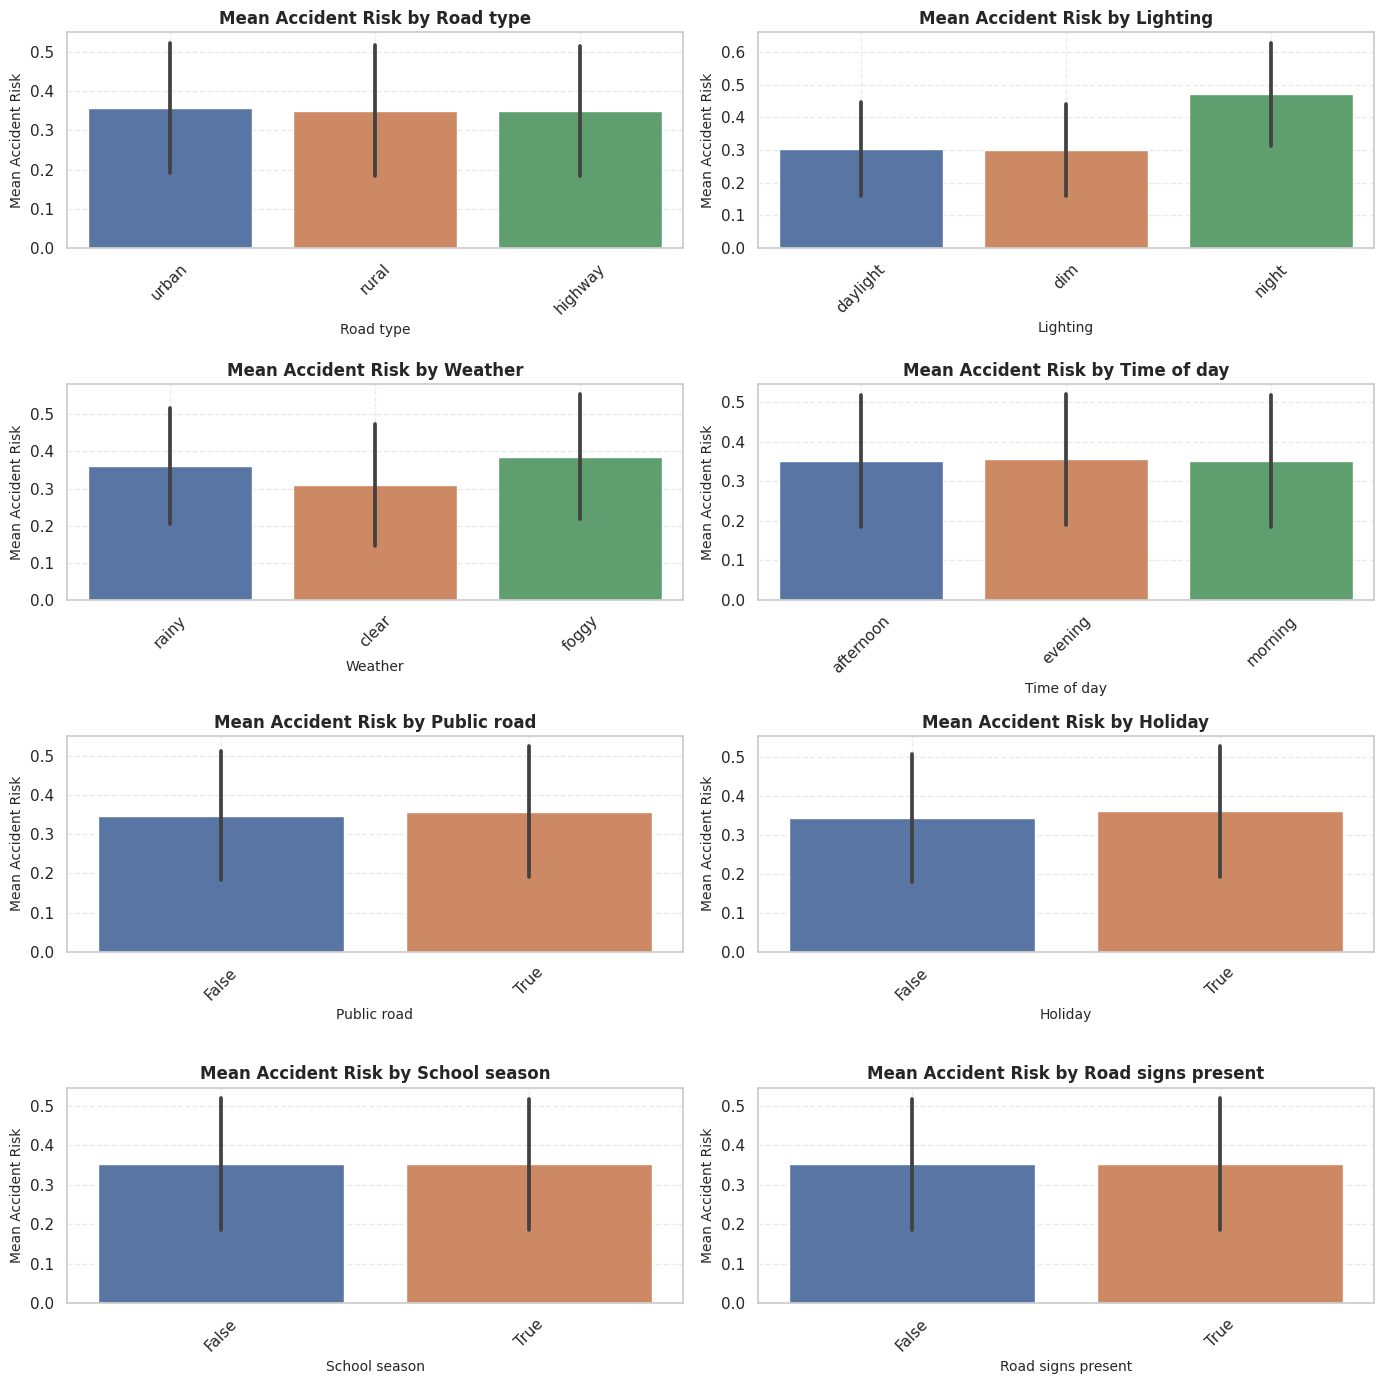

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

cat_features = [
    'road_type', 'lighting', 'weather', 'time_of_day',
    'public_road', 'holiday', 'school_season', 'road_signs_present'
]

fig, axes = plt.subplots(4, 2, figsize=(14, 14))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    sns.barplot(
        x=col,
        y='accident_risk',
        data=train,
        estimator='mean',
        errorbar='sd',
        ax=axes[i]
    )
    axes[i].set_title(f"Mean Accident Risk by {col.replace('_', ' ').capitalize()}", fontsize=12, weight='bold')
    axes[i].set_xlabel(col.replace('_', ' ').capitalize(), fontsize=10)
    axes[i].set_ylabel("Mean Accident Risk", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

### Histograms of numerical feature distributions


In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

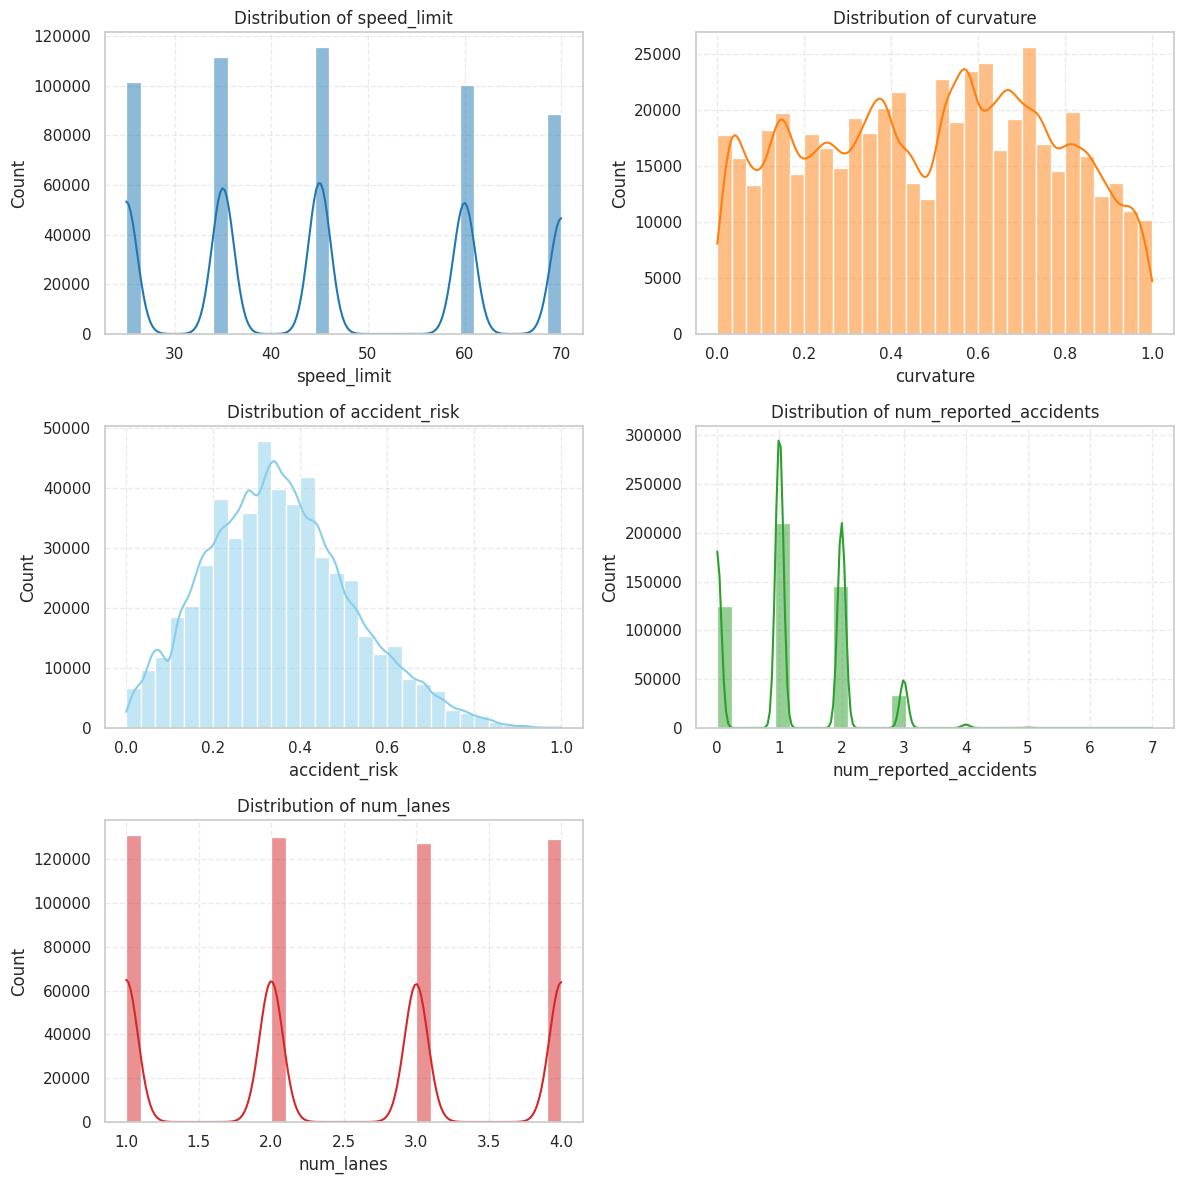

In [7]:
num_features = [
    'speed_limit', 'curvature', 'accident_risk',
    'num_reported_accidents', 'num_lanes'
]

colors = ['#1f77b4', '#ff7f0e', '#87ceeb', '#2ca02c', '#d62728']

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.histplot(train[col], bins=30, kde=True, color=colors[i], ax=axes[i])
    axes[i].set_title(f"Distribution of {col}", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].grid(True, linestyle='--', alpha=0.4)

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

### Boxplots of accident risk for discrete and binned continuous features

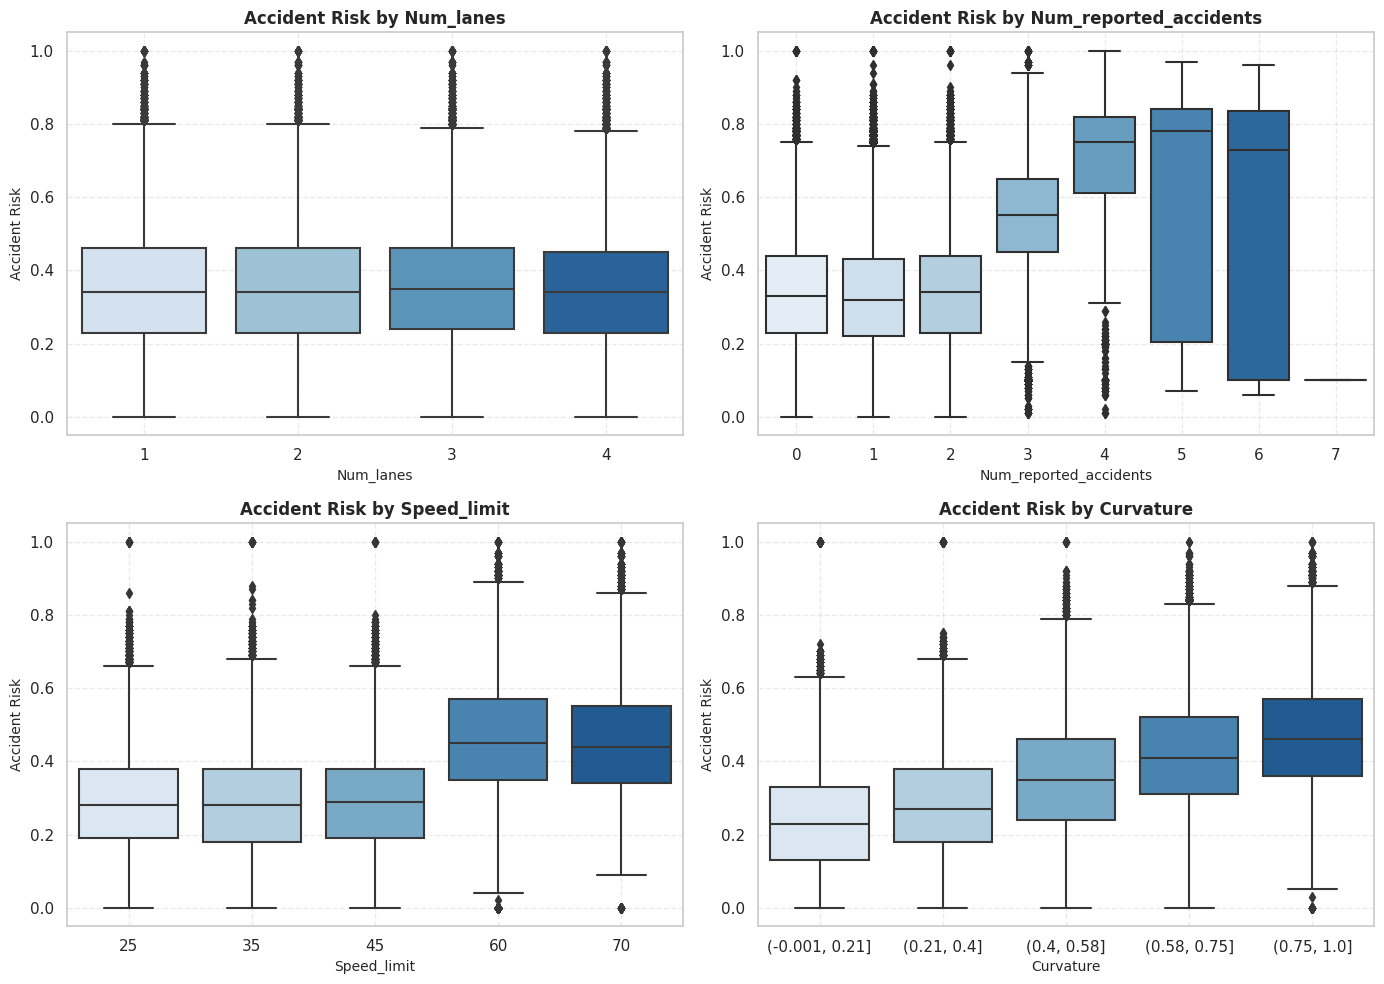

In [8]:
sns.set_theme(style="whitegrid")

discrete_features = ['num_lanes', 'num_reported_accidents', 'speed_limit']
continuous_features = ['curvature']
all_features = discrete_features + continuous_features

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(all_features):
    if col in continuous_features:
        # Bin continuous feature into 5 quantiles
        train[f'{col}_bin'] = pd.qcut(train[col], q=5, duplicates='drop')
        x_col = f'{col}_bin'
    else:
        x_col = col  # Use discrete feature as is

    sns.boxplot(
        x=x_col,
        y='accident_risk',
        data=train,
        ax=axes[i],
        palette="Blues"
    )

    axes[i].set_title(f"Accident Risk by {col.capitalize()}", fontsize=12, weight='bold')
    axes[i].set_xlabel(col.capitalize(), fontsize=10)
    axes[i].set_ylabel("Accident Risk", fontsize=10)
    axes[i].tick_params(axis='x')
    axes[i].grid(True, linestyle='--', alpha=0.4)

for j in range(len(all_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()